In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import lightgbm as lgb
import pandas as pd
import numpy as np
import sklearn
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from catboost import CatBoostRegressor

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
dfTrain = pd.read_csv('dfTrain.csv', index_col=0).reset_index()
dfTest = pd.read_csv('dfTest.csv', index_col=0).reset_index()

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722922 entries, 0 to 722921
Data columns (total 35 columns):
index                                           722922 non-null int64
channelGrouping                                 722922 non-null object
date                                            722922 non-null int64
fullVisitorId                                   722922 non-null object
visitNumber                                     722922 non-null int64
visitStartTime                                  722922 non-null int64
device.browser                                  722922 non-null object
device.deviceCategory                           722922 non-null object
device.isMobile                                 722922 non-null bool
device.operatingSystem                          722922 non-null object
geoNetwork.city                                 722922 non-null object
geoNetwork.continent                            722922 non-null object
geoNetwork.country                         

In [4]:
dfTrain.head()

,index,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,hasRevenue
0,32362,Organic Search,20161123,1873576515102506659,1,1479896783,Safari,mobile,True,iOS,...,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,False
1,670880,Social,20170224,4056856282807298046,1,1487928830,Chrome,desktop,False,Windows,...,NaN,NaN,NaN,(not set),NaN,NaN,referral,/yt/about/,youtube.com,False
2,289019,Organic Search,20161106,6238615970633772107,1,1478496118,Chrome,mobile,True,Android,...,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,False
3,681288,Organic Search,20170411,61850577046711139,1,1491906643,Chrome,desktop,False,Macintosh,...,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,False
4,383766,Organic Search,20170403,8123597710598032029,1,1491282940,Chrome,desktop,False,Windows,...,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,False


In [5]:
def checkCol(df, colName, isCata = True):
    numRow = df.shape[0]
    print(colName, ':')
    print('Any NA?: ', df[colName].isnull().values.any())
    if df[colName].isnull().values.any():
        numNA = sum(df[colName].isnull().values)
        print ('    # of NA: ', numNA)
        print ('    NA%:     ', numNA/numRow)
    if isCata:
        levelList = df[colName].unique()
        print('Different levels: ', len(levelList), levelList)
        speList = ['(not set)', '(not provided)', '(none)', '(Other)']
        for spe in speList:
            if spe in levelList:
                print(spe, 'percentage: ', sum(df[colName] == spe)/numRow)
        matplotlib.rcParams['figure.figsize'] = (12, 6)
        sns.catplot(y=colName, kind="count", data=dfTrain)
        
    else:
        print('range: ', min(df[colName].astype(float).dropna()), max(df[colName].astype(float).dropna()))
        plt.hist(df[colName])

trafficSource.source :
Any NA?:  False
Different levels:  356 ['google' 'youtube.com' '(direct)' 'mall.googleplex.com'
 'analytics.google.com' 'Partners' 'dfa' 'm.facebook.com' 't.co'
 'quora.com' 'groups.google.com' 'yahoo' 'google.com' 'blognone.com'
 'facebook.com' 'mail.google.com' 'baidu' 'duckduckgo.com'
 'l.facebook.com' 'google.co.jp' 'gist.github.com' 'bing'
 'sites.google.com' 'qiita.com' 'googleux.perksplus.com' 'reddit.com'
 '(not set)' 'plus.url.google.com' 'wap.sogou.com' 'm.yz.sm.cn'
 'sashihara.jp' 'ask' 'siliconvalley.about.com' 'moma.corp.google.com'
 'google.nl' 'm.baidu.com' 'productforums.google.com' 'seroundtable.com'
 'blog.golang.org' 'learn.colorado.edu' 'google.co.uk'
 'adwords-displayads.googleusercontent.com' 'docs.google.com'
 'images.google' 'businessinsider.com' 'googleweblight.com'
 'plus.google.com' 's0.2mdn.net' 'gdeals.googleplex.com'
 'suche.t-online.de' 'phandroid.com' 'google.be'
 'googleads.g.doubleclick.net' 'dealspotr.com' 'cv.il3.ub.edu'
 'h.ya

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


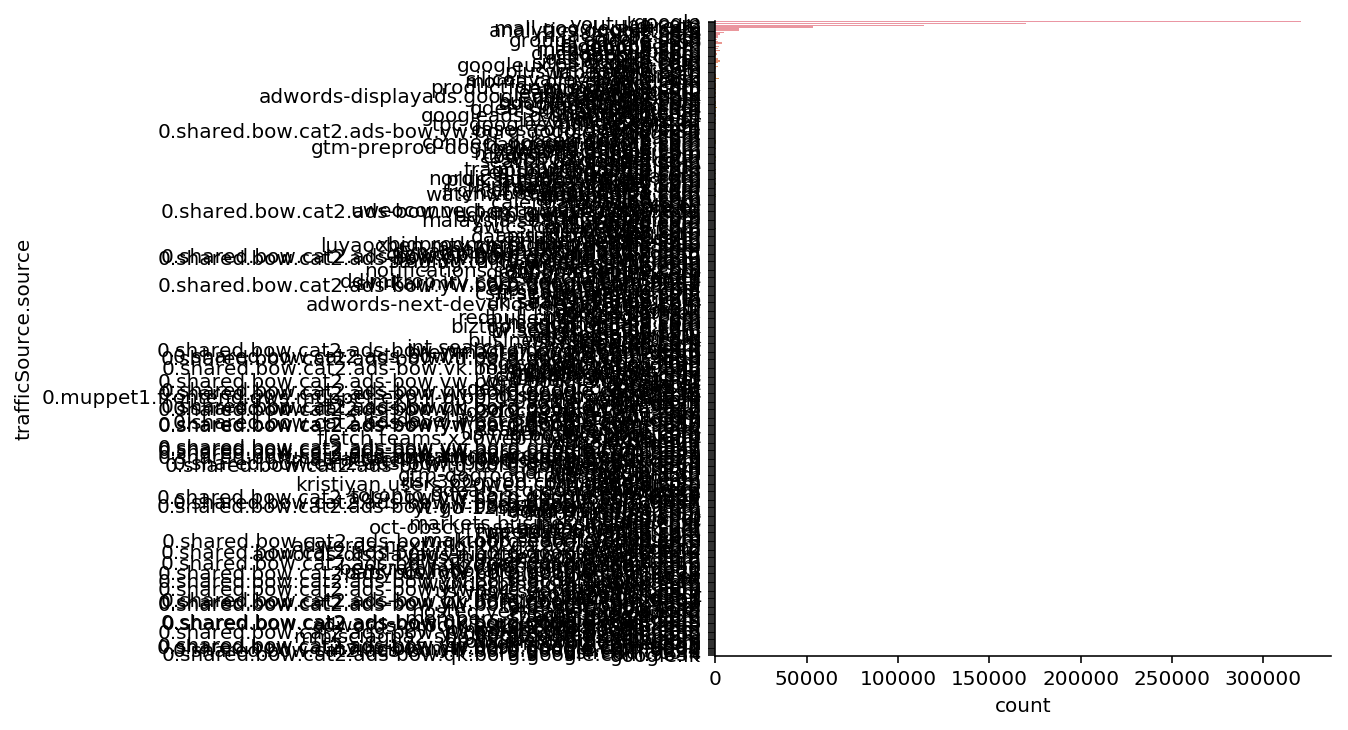

In [37]:
checkCol(dfTrain, 'trafficSource.source')

In [6]:
def changeCate(df, col, values, nor = False):
    if not nor:
        for value in values:
            df.loc[df[col] == value, col] = 'other'
    else:
        df.loc[~df[col].isin(values), col] = 'other'
    return df

In [7]:
def preprocess(df):
    drop_col = list(df.filter(regex = 'trafficSource.adwordsClickInfo.+').columns.values)
    drop_col.extend(['index', 'date', 'device.deviceCategory', 'geoNetwork.city',
                     'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.region',
                     'trafficSource.adContent', 'trafficSource.keyword', 'trafficSource.referralPath'])
    df = df.drop(drop_col, axis = 1)
    df = changeCate(df, 'channelGrouping', ['Affiliates', 'Paid Search', 'Display', '(Other)'])
    df = changeCate(df, 'device.browser', ['Safari', 'Chrome'], nor = True)
    df = changeCate(df, 'device.operatingSystem', ['iOS', 'Windows', 'Android', 'Macintosh'], nor = True)
    df = changeCate(df, 'geoNetwork.networkDomain', ['(not set)', 'unknown.unknown'], nor = True)
    df = changeCate(df, 'geoNetwork.subContinent', ['Southeast Asia', 'Northern America', 'Southern Asia',
                                                    'Eastern Asia', 'Western Europe', 'Western Asia', 'Southern Europe',
                                                    'Northern Europe', 'South America', 'Eastern Europe'], nor = True)
    df = changeCate(df, 'trafficSource.campaign', ['(not set)'], nor = True)
    df['trafficSource.isTrueDirect'].fillna(False, inplace=True)
    df = changeCate(df, 'trafficSource.medium', ['organic', 'referral', '(none)'], nor = True)
    df = changeCate(df, 'trafficSource.source', ['google', 'youtube.com', '(direct)', 'mall.googleplex.com'], nor = True)
    return df

In [24]:
def preprocess2(df):
    
    return df

In [8]:
train = preprocess(dfTrain)
cateCols = ['channelGrouping', 'device.browser', 'device.isMobile', 'device.operatingSystem', 
            'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.bounces', 'totals.newVisits',
            'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.medium', 'trafficSource.source']
for col in cateCols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))

numCols = ['visitNumber', 'visitStartTime', 'totals.hits', 'totals.pageviews']

In [9]:
test = preprocess(dfTest)
for col in cateCols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(test[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [41]:
train.head()
train.columns

Index(['channelGrouping', 'fullVisitorId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.networkDomain', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.medium',
       'trafficSource.source', 'hasRevenue'],
      dtype='object')

In [10]:
for cols in cateCols:
    train[cols] = train[cols].astype('category')
#train[cateCols] = train[cateCols].astype('category')
trainset, valset = train_test_split(train, test_size=0.2, random_state = 1)
train_X = trainset[cateCols + numCols]
train_y = np.log(trainset['totals.transactionRevenue'].values + 1)
val_X = valset[cateCols + numCols]
val_y = np.log(valset['totals.transactionRevenue'].values + 1)

In [11]:
for cols in cateCols:
    test[cols] = test[cols].astype('category')
test_X = test[cateCols + numCols]
test_y = np.log(test['totals.transactionRevenue'].values + 1)

In [43]:
train_X.dtypes

channelGrouping               category
device.browser                category
device.isMobile               category
device.operatingSystem        category
geoNetwork.networkDomain      category
geoNetwork.subContinent       category
totals.bounces                category
totals.newVisits              category
trafficSource.campaign        category
trafficSource.isTrueDirect    category
trafficSource.medium          category
trafficSource.source          category
visitNumber                      int64
visitStartTime                   int64
totals.hits                      int64
totals.pageviews                 int64
dtype: object

In [78]:
test_X.dtypes

channelGrouping               category
device.browser                category
device.isMobile               category
device.operatingSystem        category
geoNetwork.networkDomain      category
geoNetwork.subContinent       category
totals.bounces                category
totals.newVisits              category
trafficSource.campaign        category
trafficSource.isTrueDirect    category
trafficSource.medium          category
trafficSource.source          category
visitNumber                      int64
visitStartTime                   int64
totals.hits                      int64
totals.pageviews                 int64
dtype: object

In [12]:
def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = \
        precision_recall_curve(y_true, y_score)
    return auc(recall, precision, reorder=True)

#### LGBoost

In [24]:
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    lgb.plot_importance(model)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y


In [25]:
train_X_LR = trainset[cateCols + numCols]
train_y_LR = np.log(trainset['totals.transactionRevenue'].values + 1)
val_X_LR = valset[cateCols + numCols]
val_y_LR = np.log(valset['totals.transactionRevenue'].values + 1)
test_X_LR = test[cateCols + numCols]
test_y_LR = np.log(test['totals.transactionRevenue'].values + 1)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.65752
[200]	valid_0's rmse: 1.65083
[300]	valid_0's rmse: 1.64671
[400]	valid_0's rmse: 1.64943
Early stopping, best iteration is:
[303]	valid_0's rmse: 1.64643


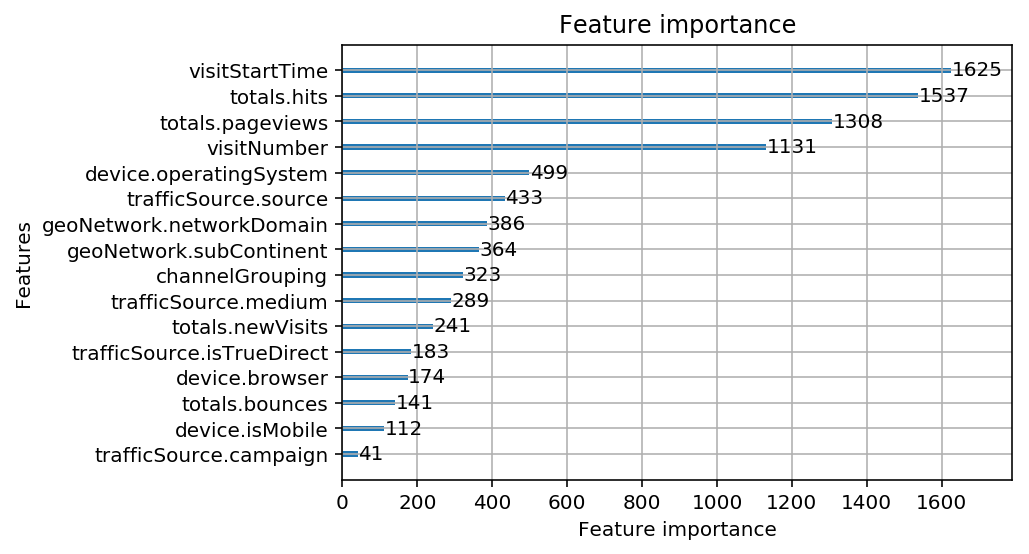

In [26]:
model, pred_val_y = run_lgb(train_X_LR, train_y_LR, val_X_LR, val_y_LR)

In [27]:
pred_val_y[pred_val_y<0] = 0
print(np.sqrt(metrics.mean_squared_error(val_y_LR, pred_val_y)))

1.6444851960168054


##### Test

In [17]:
model, pred_test_y = run_lgb(train_X_LR, train_y_LR, test_X_LR, test_y_LR)

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.63642
[200]	valid_0's rmse: 1.62901
[300]	valid_0's rmse: 1.62599
Early stopping, best iteration is:
[269]	valid_0's rmse: 1.62562


In [18]:
pred_test_y[pred_test_y<0] = 0
print(np.sqrt(metrics.mean_squared_error(test_y_LR, pred_test_y)))

1.6235739760203485


### Classification

#### Logistic regression

In [118]:
train_X_LRC = trainset[cateCols + numCols]
train_y_LRC = trainset['hasRevenue'].values
val_X_LRC = valset[cateCols + numCols]
val_y_LRC = valset['hasRevenue'].values
test_X_LRC = test[cateCols + numCols]
test_y_LRC = test['hasRevenue'].values

In [81]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, cateCols)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])

clf.fit(train_X_LRC, train_y_LRC)
print("model score: %.3f" % clf.score(val_X_LRC, val_y_LRC))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


model score: 0.988


In [82]:

print(classification_report(val_y_LRC, clf.predict(val_X_LRC)))
print(roc_auc_score(val_y_LRC, clf.predict(val_X_LRC)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

       False       0.99      1.00      0.99    142739
        True       0.53      0.19      0.28      1846

   micro avg       0.99      0.99      0.99    144585
   macro avg       0.76      0.60      0.64    144585
weighted avg       0.98      0.99      0.98    144585



C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5950469307347945


In [83]:
pr_auc_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1])

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


0.4022902540256168

In [91]:
roc_curve(val_y_LRC, clf.predict(val_X_LRC))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


(array([0.        , 0.00221383, 1.        ]),
 array([0.        , 0.19230769, 1.        ]),
 array([2, 1, 0]))

In [84]:
print(roc_auc_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9782391297082643


In [86]:
thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for t in thresholds:
    print('threshold {}'.format(t))
    print(f1_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]>t))

threshold 0


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.025213240365769544
threshold 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.47652625719057334
threshold 0.2


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.4630781714903976
threshold 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.40706260032102726
threshold 0.4


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.3456254519161243
threshold 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.2820818434644418
threshold 0.6


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.2389193752638244
threshold 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.1858603823921743
threshold 0.8


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.13352139163140572
threshold 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.08730158730158731
threshold 1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.0


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [87]:
print(classification_report(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]>0.1))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

       False       1.00      0.98      0.99    142739
        True       0.36      0.70      0.48      1846

   micro avg       0.98      0.98      0.98    144585
   macro avg       0.68      0.84      0.73    144585
weighted avg       0.99      0.98      0.98    144585



##### Test

In [119]:
print(classification_report(test_y_LRC, clf.predict(test_X_LRC)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

       False       0.99      1.00      0.99    178438
        True       0.53      0.19      0.28      2293

   micro avg       0.99      0.99      0.99    180731
   macro avg       0.76      0.60      0.64    180731
weighted avg       0.98      0.99      0.98    180731



#### Logistic Regression with OverSampling

In [154]:
ros = RandomOverSampler(random_state=0, sampling_strategy = 0.05)
X_resampled, y_resampled = ros.fit_resample(train_X_LRC, train_y_LRC)
X_resampled = pd.DataFrame(X_resampled, columns=train_X_LRC.columns)

In [155]:
clf.fit(X_resampled, y_resampled)
print("model score: %.3f" % clf.score(val_X_LRC, val_y_LRC))
print(classification_report(val_y_LRC, clf.predict(val_X_LRC)))
print(roc_auc_score(val_y_LRC, clf.predict(val_X_LRC)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


model score: 0.985


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

       False       0.99      0.99      0.99    142739
        True       0.43      0.53      0.47      1846

   micro avg       0.98      0.98      0.98    144585
   macro avg       0.71      0.76      0.73    144585
weighted avg       0.99      0.98      0.99    144585



C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.7587006588793461


In [72]:
print(roc_auc_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9809862509816747


In [48]:
pr_auc_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1])

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


0.3988852449619253

In [93]:
thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for t in thresholds:
    print('threshold {}'.format(t))
    print(f1_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]>t))

threshold 0


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.025213240365769544
threshold 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.2966276668960771
threshold 0.2


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.43842645381984036
threshold 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.4814881704894347
threshold 0.4


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.48309382924767535
threshold 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.4715013339801115
threshold 0.6


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.4475409836065574
threshold 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.41282442748091597
threshold 0.8


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.35677530017152653
threshold 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.27272727272727276
threshold 1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.0


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [94]:
print(classification_report(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]>0.4))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

       False       1.00      0.99      0.99    142739
        True       0.40      0.62      0.48      1846

   micro avg       0.98      0.98      0.98    144585
   macro avg       0.70      0.80      0.74    144585
weighted avg       0.99      0.98      0.98    144585



In [146]:
for cols in cateCols:
    X_resampled[cols] = X_resampled[cols].astype('category')
#X_resampled[cateCols] = X_resampled[cateCols].astype('category')
X_resampled[numCols] = X_resampled[numCols].astype(int)
X_resampled.dtypes

channelGrouping               category
device.browser                category
device.isMobile               category
device.operatingSystem        category
geoNetwork.networkDomain      category
geoNetwork.subContinent       category
totals.bounces                category
totals.newVisits              category
trafficSource.campaign        category
trafficSource.isTrueDirect    category
trafficSource.medium          category
trafficSource.source          category
visitNumber                      int32
visitStartTime                   int32
totals.hits                      int32
totals.pageviews                 int32
dtype: object

In [47]:
print('Original dataset shape %s' % Counter(train_y_LRC))
print('Resampled dataset shape %s' % Counter(y_resampled))

Original dataset shape Counter({False: 570961, True: 7376})
Resampled dataset shape Counter({False: 570961, True: 28548})


#### Logistic Regression with SMOTE

In [110]:
sm = SMOTE(random_state=0)
X_smote, y_smote = sm.fit_resample(train_X_LRC, train_y_LRC)
print('Original dataset shape %s' % Counter(train_y_LRC))
print('SMOTE dataset shape %s' % Counter(y_smote))

Original dataset shape Counter({False: 570961, True: 7376})
SMOTE dataset shape Counter({False: 570961, True: 570961})


In [111]:
X_smote = pd.DataFrame(X_smote, columns=train_X_LRC.columns)
clf.fit(X_smote, y_smote)
print("model score: %.3f" % clf.score(val_X_LRC, val_y_LRC))
print(classification_report(val_y_LRC, clf.predict(val_X_LRC)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


model score: 0.985


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

       False       0.99      0.99      0.99    142739
        True       0.43      0.52      0.47      1846

   micro avg       0.99      0.99      0.99    144585
   macro avg       0.71      0.75      0.73    144585
weighted avg       0.99      0.99      0.99    144585



In [51]:
print(roc_auc_score(val_y_LRC, clf.predict(val_X_LRC)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.7536910096697639


In [53]:
print(roc_auc_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9743363219128699


In [54]:
pr_auc_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1])

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


0.3815130542122915

In [97]:
thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for t in thresholds:
    print('threshold {}'.format(t))
    print(f1_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]>t))

threshold 0


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.025213240365769544
threshold 0.1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.30898653998416464
threshold 0.2


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.3898012100259291
threshold 0.3


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.4468960359012715
threshold 0.4


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.4723859419340755
threshold 0.5


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.4688806888068881
threshold 0.6


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.4537953795379538
threshold 0.7


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.4256488549618321
threshold 0.8


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.3761969904240766
threshold 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.30163678877630556
threshold 1


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.0


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
print(classification_report(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]>0.4))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

       False       0.99      0.99      0.99    142739
        True       0.40      0.59      0.47      1846

   micro avg       0.98      0.98      0.98    144585
   macro avg       0.70      0.79      0.73    144585
weighted avg       0.99      0.98      0.98    144585



In [112]:
for cols in cateCols:
    X_smote[cols] = X_smote[cols].astype('category')
#X_resampled[cateCols] = X_resampled[cateCols].astype('category')
X_smote[numCols] = X_smote[numCols].astype(int)
X_smote.dtypes

channelGrouping               category
device.browser                category
device.isMobile               category
device.operatingSystem        category
geoNetwork.networkDomain      category
geoNetwork.subContinent       category
totals.bounces                category
totals.newVisits              category
trafficSource.campaign        category
trafficSource.isTrueDirect    category
trafficSource.medium          category
trafficSource.source          category
visitNumber                      int32
visitStartTime                   int32
totals.hits                      int32
totals.pageviews                 int32
dtype: object

In [56]:
sm = SMOTE(random_state=0, sampling_strategy = 0.05)
X_smote, y_smote = sm.fit_resample(train_X_LRC, train_y_LRC)
print('Original dataset shape %s' % Counter(train_y_LRC))
print('SMOTE dataset shape %s' % Counter(y_smote))

Original dataset shape Counter({False: 570961, True: 7376})
SMOTE dataset shape Counter({False: 570961, True: 28548})


In [57]:
X_smote = pd.DataFrame(X_smote, columns=train_X_LRC.columns)
clf.fit(X_smote, y_smote)
print("model score: %.3f" % clf.score(val_X_LRC, val_y_LRC))
print(classification_report(val_y_LRC, clf.predict(val_X_LRC)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


model score: 0.987


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


              precision    recall  f1-score   support

       False       0.99      1.00      0.99    142739
        True       0.52      0.23      0.32      1846

   micro avg       0.99      0.99      0.99    144585
   macro avg       0.76      0.61      0.66    144585
weighted avg       0.98      0.99      0.99    144585



In [58]:
print(roc_auc_score(val_y_LRC, clf.predict(val_X_LRC)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.6124073617549102


In [60]:
print(roc_auc_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9776202630843315


In [59]:
pr_auc_score(val_y_LRC, clf.predict_proba(val_X_LRC)[:,1])

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


0.3985118985974418

In [107]:
for cols in cateCols:
    X_smote[cols] = X_smote[cols].astype('category')
#X_resampled[cateCols] = X_resampled[cateCols].astype('category')
X_smote[numCols] = X_smote[numCols].astype(int)
X_smote.dtypes

channelGrouping               category
device.browser                category
device.isMobile               category
device.operatingSystem        category
geoNetwork.networkDomain      category
geoNetwork.subContinent       category
totals.bounces                category
totals.newVisits              category
trafficSource.campaign        category
trafficSource.isTrueDirect    category
trafficSource.medium          category
trafficSource.source          category
visitNumber                      int32
visitStartTime                   int32
totals.hits                      int32
totals.pageviews                 int32
dtype: object

#### LightGBM Classification

In [86]:
def run_lgbc(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "binary",
        "metric" : "binary_logloss", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y

In [116]:
modelC, pred_val_y = run_lgbc(train_X_LRC, train_y_LRC, val_X_LRC, val_y_LRC)

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.0277848
[200]	valid_0's binary_logloss: 0.131432
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.0277447


In [64]:
print(classification_report(val_y_LRC, modelC.predict(val_X_LRC)>0.5))
print(metrics.accuracy_score(val_y_LRC, modelC.predict(val_X_LRC)>0.5))
print(roc_auc_score(val_y_LRC, modelC.predict(val_X_LRC)>0.5))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99    142739
        True       0.59      0.23      0.34      1846

   micro avg       0.99      0.99      0.99    144585
   macro avg       0.79      0.62      0.66    144585
weighted avg       0.99      0.99      0.99    144585

0.9881453816094339
0.6162262347516108


In [65]:
modelC.predict(val_X_LRC)

array([1.14748103e-06, 2.06848737e-06, 7.06589764e-07, ...,
       4.06839051e-02, 2.49426375e-01, 1.18132586e-06])

In [68]:
print(roc_auc_score(val_y_LRC, modelC.predict(val_X_LRC)))
print(pr_auc_score(val_y_LRC, modelC.predict(val_X_LRC)))

0.9874223173788992
0.4697715058373113


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


In [118]:
thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for t in thresholds:
    print('threshold {}'.format(t))
    print(f1_score(val_y_LRC, modelC.predict(val_X_LRC)>t))

threshold 0
0.025213240365769544
threshold 0.1
0.4509423503325943
threshold 0.2
0.49477221807318894
threshold 0.3
0.4961352657004831
threshold 0.4
0.44499381953028433
threshold 0.5
0.3356589147286822
threshold 0.6
0.16129032258064516
threshold 0.7
0.03181336161187699
threshold 0.8
0.0
threshold 0.9


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0
threshold 1
0.0


In [119]:
print(classification_report(val_y_LRC, modelC.predict(val_X_LRC)>0.3))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99    142739
        True       0.45      0.56      0.50      1846

   micro avg       0.99      0.99      0.99    144585
   macro avg       0.72      0.77      0.74    144585
weighted avg       0.99      0.99      0.99    144585



#### LightGBM Classification with OverSampling

In [147]:
modelC, pred_val_y = run_lgbc(X_resampled, y_resampled, val_X_LRC, val_y_LRC)

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.0364319
[200]	valid_0's binary_logloss: 0.036756
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.0361961


In [89]:
print(classification_report(val_y_LRC, modelC.predict(val_X_LRC)>0.5))
print(metrics.accuracy_score(val_y_LRC, modelC.predict(val_X_LRC)>0.5))
print(roc_auc_score(val_y_LRC, modelC.predict(val_X_LRC)>0.5))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99    142739
        True       0.39      0.71      0.50      1846

   micro avg       0.98      0.98      0.98    144585
   macro avg       0.69      0.85      0.75    144585
weighted avg       0.99      0.98      0.98    144585

0.9821765743334371
0.8460677044921566


In [77]:
print(roc_auc_score(val_y_LRC, modelC.predict(val_X_LRC)))
print(pr_auc_score(val_y_LRC, modelC.predict(val_X_LRC)))

0.9875121668740309
0.4650418351808162


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


In [106]:
thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for t in thresholds:
    print('threshold {}'.format(t))
    print(f1_score(val_y_LRC, modelC.predict(val_X_LRC)>t))

threshold 0
0.025337826245101606
threshold 0.1
0.35480000000000006
threshold 0.2
0.4132171387073348
threshold 0.3
0.45375560538116594
threshold 0.4
0.48059508408796897
threshold 0.5
0.5029893924783028
threshold 0.6
0.5007045561296384
threshold 0.7
0.4552261156034741
threshold 0.8
0.28865131578947373
threshold 0.9
0.00964630225080386
threshold 1
0.0


##### Test

In [123]:
print(classification_report(test_y_LRC, modelC.predict(test_X_LRC)>0.5))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99    178438
        True       0.40      0.73      0.52      2293

   micro avg       0.98      0.98      0.98    180731
   macro avg       0.70      0.86      0.76    180731
weighted avg       0.99      0.98      0.99    180731



In [114]:
modelC.predict(test_X_LRC)

array([3.20930591e-06, 3.76824830e-06, 3.27444145e-07, ...,
       4.19498009e-06, 1.80671485e-04, 9.11943538e-03])

In [92]:
val_y_LRC

array([False, False, False, ..., False, False, False])

#### LightGBM Classification with SMOTE

In [113]:
modelC, pred_val_y = run_lgbc(X_smote, y_smote, val_X_LRC, val_y_LRC)


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.0525258
[200]	valid_0's binary_logloss: 0.0498024
[300]	valid_0's binary_logloss: 0.0491613
[400]	valid_0's binary_logloss: 0.0490201
Early stopping, best iteration is:
[368]	valid_0's binary_logloss: 0.0485076


In [115]:
print(classification_report(val_y_LRC, modelC.predict(val_X_LRC)>0.5))
print(metrics.accuracy_score(val_y_LRC, modelC.predict(val_X_LRC)>0.5))
print(roc_auc_score(val_y_LRC, modelC.predict(val_X_LRC)>0.5))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99    142739
        True       0.34      0.64      0.45      1846

   micro avg       0.98      0.98      0.98    144585
   macro avg       0.67      0.81      0.72    144585
weighted avg       0.99      0.98      0.98    144585

0.9796244423695404
0.8126927746060726


In [80]:
print(roc_auc_score(val_y_LRC, modelC.predict(val_X_LRC)))
print(pr_auc_score(val_y_LRC, modelC.predict(val_X_LRC)))

0.9871099390528578
0.4361082269185719


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


In [114]:
thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for t in thresholds:
    print('threshold {}'.format(t))
    print(f1_score(val_y_LRC, modelC.predict(val_X_LRC)>t))

threshold 0
0.028249192770899965
threshold 0.1
0.38896615669911916
threshold 0.2
0.42255823457294645
threshold 0.3
0.44036979969183365
threshold 0.4
0.44542823088711053
threshold 0.5
0.445615355664283
threshold 0.6
0.4420564686051412
threshold 0.7
0.4341048653755314
threshold 0.8
0.39902280130293155
threshold 0.9
0.33399866932801064
threshold 1
0.0


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Regression

#### Linear regression

In [160]:
trainsetLR = trainset[trainset['hasRevenue']]
train_X_LR = trainsetLR[cateCols + numCols]
train_y_LR = np.log(trainsetLR['totals.transactionRevenue'].values + 1)
valsetLR = valset[valset['hasRevenue']]
val_X_LR = valsetLR[cateCols + numCols]
val_y_LR = np.log(valsetLR['totals.transactionRevenue'].values + 1)
testsetLR = test[test['hasRevenue']]
test_X_LR = testsetLR[cateCols + numCols]
test_y_LR = np.log(testsetLR['totals.transactionRevenue'].values + 1)


In [161]:
starttime = time.time()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, cateCols)])
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])
lr.fit(train_X_LR, train_y_LR)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_LR, lr.predict(val_X_LR))))
print(lr.score(train_X_LR, train_y_LR))

time: 0.06482672691345215
1.158590728808531
0.15307436083420267


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


##### Test

In [132]:
starttime = time.time()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, cateCols)])
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])
lr.fit(train_X_LR, train_y_LR)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(test_y_LR, lr.predict(test_X_LR))))

time: 0.05983877182006836
1.0931703756689766


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### LGB regression

In [148]:
starttime = time.time()
modelR, pred_val_y = run_lgb(train_X_LR, train_y_LR, val_X_LR, val_y_LR)
print('time: {}'.format(time.time()-starttime))
#print(np.sqrt(metrics.mean_squared_error(val_y_LR, model.predict(val_X_LR))))
print(np.sqrt(metrics.mean_squared_error(val_y_LR, pred_val_y)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.11013
Early stopping, best iteration is:
[71]	valid_0's rmse: 1.10817
time: 0.386962890625
1.1081722280341082


In [137]:
starttime = time.time()
modelR, pred_test_y = run_lgb(train_X_LR, train_y_LR, test_X_LR, test_y_LR)
print('time: {}'.format(time.time()-starttime))
#print(np.sqrt(metrics.mean_squared_error(val_y_LR, model.predict(val_X_LR))))
print(np.sqrt(metrics.mean_squared_error(test_y_LR, pred_test_y)))

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.06141
Early stopping, best iteration is:
[56]	valid_0's rmse: 1.05986
time: 0.3337075710296631
1.0598636471378275


#### XGBoost

In [139]:
def run_xgb(X_train, y_train, X_val, y_val):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train.values, y_train.values)
    xgb_val_data = xgb.DMatrix(X_val.values, y_val.values)
    #xgb_submit_data = xgb.DMatrix(X_test)
    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=2000, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    y_pred_val = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    #y_pred_submit = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    return model, y_pred_val 

In [123]:
starttime = time.time()
xgb_model, xgb_preds = run_xgb(train_X_LR, pd.DataFrame(train_y_LR), val_X_LR, pd.DataFrame(val_y_LR))
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_LR, xgb_preds)))

[0]	train-rmse:17.3331	valid-rmse:17.3771
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:10.5527	valid-rmse:10.5959
[1000]	train-rmse:6.46309	valid-rmse:6.50717
[1500]	train-rmse:4.01722	valid-rmse:4.06378
[1999]	train-rmse:2.58529	valid-rmse:2.64047
time: 14.23649549484253
2.640467515354605


In [142]:
starttime = time.time()
xgb_model, xgb_preds = run_xgb(train_X_LR, pd.DataFrame(train_y_LR), test_X_LR, pd.DataFrame(test_y_LR))
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(test_y_LR, xgb_preds)))

[0]	train-rmse:17.3331	valid-rmse:17.3713
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:10.5527	valid-rmse:10.5882
[1000]	train-rmse:6.46309	valid-rmse:6.49585
[1500]	train-rmse:4.01722	valid-rmse:4.04811
[1999]	train-rmse:2.58529	valid-rmse:2.61788
time: 13.580903053283691
2.6178792726271207


#### CatBoost

In [143]:
def run_catboost(X_train, y_train, X_val, y_val):
    model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=False)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
   # y_pred_submit = model.predict(X_test)

    return model, y_pred_val

In [125]:
starttime = time.time()
cat_model, cat_preds = run_catboost(train_X_LR, train_y_LR, val_X_LR, val_y_LR)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(val_y_LR, cat_preds)))

time: 21.337007522583008
1.134015227128452


In [144]:
starttime = time.time()
cat_model, cat_preds = run_catboost(train_X_LR, train_y_LR, test_X_LR, test_y_LR)
print('time: {}'.format(time.time()-starttime))
print(np.sqrt(metrics.mean_squared_error(test_y_LR, cat_preds)))

time: 16.987916469573975
1.0890722209776038


### Itegrated Models

#### LGB Pipeline

In [78]:
val_X['pred_hasRevenue'] = modelC.predict(val_X)>0.5
val_X['pred_Revenue'] = modelR.predict(val_X)
pred = val_X['pred_hasRevenue'].values * val_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(val_y, pred)))

/Users/Tianyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2.377435647373111


/Users/Tianyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Random oversampling

In [55]:
val_X['pred_hasRevenue'] = modelC.predict(val_X)>0.5
val_X['pred_Revenue'] = modelR.predict(val_X)
pred = val_X['pred_hasRevenue'].values * val_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(val_y, pred)))

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2.377435647373111


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Test

In [149]:
test_X['pred_hasRevenue'] = modelC.predict(test_X)>0.5
test_X['pred_Revenue'] = modelR.predict(test_X)
pred = test_X['pred_hasRevenue'].values * test_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(test_y, pred)))

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2.325744329363576


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Logistic Regression + OLS

In [79]:
val_X['pred_hasRevenue'] = clf.predict(val_X)>0.5
val_X['pred_Revenue'] = lr.predict(val_X)
pred = val_X['pred_hasRevenue'].values * val_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(val_y, pred)))

/Users/Tianyi/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/Tianyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Tianyi/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


2.1908873710056307


/Users/Tianyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
val_X['pred_hasRevenue'] = clf.predict(val_X)>0.4
val_X['pred_Revenue'] = lr.predict(val_X)
pred = val_X['pred_hasRevenue'].values * val_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(val_y, pred)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


2.1907091211275564


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Test

In [164]:
test_X['pred_hasRevenue'] = clf.predict(test_X)>0.4
test_X['pred_Revenue'] = lr.predict(test_X)
pred = test_X['pred_hasRevenue'].values * test_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(test_y, pred)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


2.1470311515444513


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### LightGBM + OLS

In [96]:
val_X['pred_hasRevenue'] = modelC.predict(val_X)>0.5
val_X['pred_Revenue'] = lr.predict(val_X)
pred = val_X['pred_hasRevenue'].values * val_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(val_y, pred)))

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


2.5441191304091784


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [152]:
val_X['pred_hasRevenue'] = modelC.predict(val_X)>0.5
val_X['pred_Revenue'] = lr.predict(val_X)
pred = val_X['pred_hasRevenue'].values * val_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(val_y, pred)))

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


2.3764584089117013


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Test

In [153]:
test_X['pred_hasRevenue'] = modelC.predict(test_X)>0.5
test_X['pred_Revenue'] = lr.predict(test_X)
pred = test_X['pred_hasRevenue'].values * test_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(test_y, pred)))

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


2.3238962418394347


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Logistic Regression + LGB regression

In [97]:
val_X['pred_hasRevenue'] = clf.predict(val_X)>0.5
val_X['pred_Revenue'] = modelR.predict(val_X)
pred = val_X['pred_hasRevenue'].values * val_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(val_y, pred)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2.1834020357505755


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [156]:
val_X['pred_hasRevenue'] = clf.predict(val_X)>0.4
val_X['pred_Revenue'] = modelR.predict(val_X)
pred = val_X['pred_hasRevenue'].values * val_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(val_y, pred)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2.195045626271284


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Test

In [159]:
test_X['pred_hasRevenue'] = clf.predict(test_X)>0.4
test_X['pred_Revenue'] = modelR.predict(test_X)
pred = test_X['pred_hasRevenue'].values * test_X['pred_Revenue'].values
pred[pred<0] = 0
print(np.sqrt(metrics.mean_squared_error(test_y, pred)))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2.1526357088809944


C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
